In [ ]:
try:
  import mat73
except:
  !pip install -q mat73
  import mat73

try:
  import hdf5storage
except:
  !pip install hdf5storage

In [ ]:
import os
import numpy as np
import numba as nb
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import hdf5storage
import gdown
import warnings
import time
timestr = time.strftime("%Y-%m-%d_%H.%M.%S")

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HOSVD

In [ ]:
def matlen(var):
    '''Equivalent to Matlab's length()'''
    if np.size(np.shape(var))==1:
        x = np.size(var)
    else:
        x = max(np.shape(var))
    return x

def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))


def fold(B,dim,shape):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H),i,shap)
    return T

def svdtrunc(A, n):
    '''Truncated svd'''
    U, S, _ = randomized_svd(A, n_components = n)
    return U, S

In [ ]:
def HOSVD_function(T,varepsilon1):
    '''Perform hosvd to tensor'''
    P = T.ndim
    U = np.zeros(shape=(1,P), dtype=object)
    UT = np.zeros(shape=(1,P), dtype=object)
    sv = np.zeros(shape=(1,P), dtype=object)
    producto = np.size(T)

    if isinstance(varepsilon1, (list, np.ndarray)):
        n = varepsilon1
    else:
        n = T.shape

    n = list(n)

    for i in range(0,P):
        n[i] = int(np.amin((n[i],producto/n[i])))
        A = unfold(T, i)

        Uaux = []
        # SVD based reduction of the current dimension (i):
        Ui, svi = svdtrunc(A, n[i])

        if n[i] < 2:
            Uaux = np.zeros((np.shape(Ui)[0],2))
            Uaux[:,0] = Ui[:,0]
            U[0][i] = Uaux
        else:
            if isinstance(varepsilon1, (list, np.ndarray)):
                pass
            else:
                count = 0
                for j in range(0,np.shape(svi)[0]):
                    if svi[j]/svi[0]<=varepsilon1:
                        pass
                    else:
                        count = count+1
                n[i] = count
            U[0][i] = Ui[:,0:n[i]]

        UT[0][i] = np.transpose(U[0][i])
        sv[0][i] = svi
    S = tprod(T, UT)
    TT = tprod(S, U)
    return TT, S, U, sv, n

In [ ]:
def HOSVD(Tensor,varepsilon1,nn,n,TimePos):
    '''Perform hosvd to input data and retain all the singular values'''

    if np.iscomplex(Tensor.any()) == False:
        Tensor = Tensor.astype(np.float32)
    [TT,S2,U,sv,nn2] = HOSVD_function(Tensor,varepsilon1)

    print(f'Initial number of singular values: {n}')
    print(f'Number of singular values retained: {nn2}')

    UT = np.zeros(shape=np.shape(U), dtype=object)
    hatT = []
    for pp in range(0,np.size(nn2)):
        UT[0][pp] = np.transpose(U[0][pp])
    for kk in range(0,nn2[TimePos-1]):
        hatT.append(np.dot(sv[0][TimePos-1][kk],UT[0][TimePos-1][kk,:]))
    hatT = np.reshape(hatT, newshape=(len(hatT),np.size(hatT[0])))
    return hatT,U,S2,sv,nn2,n,TT

# DEFINE NECESSARY FUNCTIONS FOR PERFORMING HODMD

In [ ]:
def matlen(var):
    '''Equivalent to Matlab's length()'''
    if np.size(np.shape(var))==1:
        x = np.size(var)
    else:
        x = max(np.shape(var))
    return x

def error(V,Vrec):
    '''Relative RMS and max errors'''
    return np.linalg.norm(V-Vrec)/np.linalg.norm(V),np.linalg.norm(V-Vrec,np.inf)/np.linalg.norm(V,np.inf)

# @nb.njit(cache=True)

def truncatedSVD(A,esvd):
    '''Decomposition into singular values, truncated on esvd'''
    U,s,Wh=np.linalg.svd(A,full_matrices=False)
    n=0
    norm=np.linalg.norm(s)
    for i in range(s.size):
        if np.linalg.norm(s[i:])/norm<=esvd:
            break
        else:
            n+=1
    return U[:,:n],s[:n],Wh[:n,:]

def unfold(A,dim):
    '''Turns tensor into matrix keeping the columns on dim'''
    ax=np.arange(A.ndim)
    return np.reshape(np.moveaxis(A,ax,np.roll(ax,dim)),(A.shape[dim],A.size//A.shape[dim]))

def fold(B,shape,dim):
    '''Reverse operation to the unfold function'''
    ax=np.arange(len(shape))
    shape=np.roll(shape,-dim)
    A=np.reshape(B,shape)
    return np.moveaxis(A,ax,np.roll(ax,-dim))

def tprod(S,U):
    '''Tensor product of an ndim-array and multiple matrices'''
    T = S
    shap = list(np.shape(S))
    for i in range(0,np.size(U)):
        x = np.count_nonzero(U[0][i])
        if not x==0:
            shap[i] = np.shape(U[0][i])[0]
            H = unfold(T,i)
            T = fold(np.dot(U[0][i],H), shap, i)
    return T

def tensormatmul(S,U,dim):
    '''Internal product of tensor and matrix in dim'''
    shape=np.array(S.shape)
    shape[dim]=U.shape[0]
    return fold(U@unfold(S,dim),shape,dim)

def truncHOSVD(A,esvd):
    '''Decomposition into singular values for tensors, truncated in esvd'''
    Ulist=[]
    slist=[]
    S=A.copy()
    for i in range(A.ndim):
        [U,s,Vh]=truncatedSVD(unfold(A,i),esvd/np.sqrt(A.ndim))
        Ulist.append(U)
        S=tensormatmul(S,U.T,i)
    for i in range(A.ndim):
        s=np.zeros(S.shape[0])
        ax=np.arange(A.ndim)
        for j in range(S.shape[0]):
            s[j]=np.linalg.norm(S[j])
        slist.append(s)
        S=np.moveaxis(S,ax,np.roll(ax,1))
    return S,Ulist,slist

In [ ]:
def dmd1(V,t,esvd,edmd):
    '''First order dynamic modal decomposition:
        Input:
            -V (IxJ): Snapshot matrix.
            -t (J): Time vector.
            -esvd: First tolerance (SVD).
            -edmd: Second tolerance (DMD modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]

    # Reduced snapshots:
    U,s,Wh=truncatedSVD(V,esvd)
    Vvir=np.diag(s)@Wh
    n=s.size

    # Spatial complexity kk:
    NormS=np.linalg.norm(s,ord=2)
    kk=0
    for k in range(0,n):
        if np.linalg.norm(s[k:n],2)/NormS>esvd:
            kk=kk+1
    print(f'Spatial complexity: {kk}')

    # Koopman matrix reconstruction:
    Uvir,svir,Wvirh=np.linalg.svd(Vvir[:,:-1],full_matrices=False) #r'*r', r'*r', r'*(J-1)
    Rvir=Vvir[:,1:]@Wvirh.conj().T@np.diag(svir**-1)@Uvir.conj().T #r'*r'
    eigval,eigvec=np.linalg.eig(Rvir) #r'*r'

    # Frequencies and Growthrate:
    delta=np.log(eigval).real/dt #r'
    omega=np.log(eigval).imag/dt #r'

    # Amplitudes:
    A=np.zeros((eigvec.shape[0]*Vvir.shape[1],eigvec.shape[1]))
    b=np.zeros(eigvec.shape[0]*Vvir.shape[1])
    for i in range(Vvir.shape[1]):
        A[i*eigvec.shape[0]:(i+1)*eigvec.shape[0],:]=eigvec@np.diag(eigval**i)
        b[i*eigvec.shape[0]:(i+1)*eigvec.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False)
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b

    # Modes:
    uvir=eigvec@np.diag(a)
    u=U@uvir

    areal=np.linalg.norm(u,axis=0)/np.sqrt(V.shape[0])

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    idx=np.flip(np.argsort(areal))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    # Filter important ones:
    mask=(areal/areal[0])>edmd

    # Mode Matrix:
    ModeMatr=np.zeros((kk3,4))
    for ii in range(0,kk3):
        ModeMatr[ii,0]=ii+1
        ModeMatr[ii,1]=delta[mask][ii]
        ModeMatr[ii,2]=omega[mask][ii]
        ModeMatr[ii,3]=areal[mask][ii]

    # Calculate modes:
    u=u[:,mask]
    U = U[:,0:kk]
    DMDmode=np.zeros((V.shape[0],kk3),dtype=np.complex128)
    Amplitude0=np.zeros(kk3)
    for m in range(0,kk3):
        NormMode=np.linalg.norm(np.dot(U,u[:,m]),ord=2)/np.sqrt(V.shape[0])
        Amplitude0[m]=NormMode
        DMDmode[:,m]=np.dot(U,u[:,m])/NormMode

    return u,areal[mask],eigval[mask],delta[mask],omega[mask],DMDmode

In [ ]:
def hodmd(V,d,t,esvd,edmd):
    '''High order (d) modal decomposition:
        Input:
            -V (IxJ): snapshot matrix.
            -t (J): time vector.
            -d: parameter of DMD-d, higher order Koopman assumption (int>=1).
            -esvd: first tolerance (SVD).
            -edmd: second tolerance (DMD-d modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]

    # Reduced snapshots:
    U,s,Wh=truncatedSVD(V,esvd)
    Vvir=np.diag(s)@Wh
    n=s.size

    # Spatial complexity kk:
    NormS=np.linalg.norm(s,ord=2)
    kk=0
    for k in range(0,n):
        if np.linalg.norm(s[k:n],2)/NormS>esvd:
            kk=kk+1
    print(f'Spatial complexity: {kk}')

    # Reduced and grouped snapshots:
    Vdot=np.zeros((d*n,Vvir.shape[1]-d+1),dtype=Vvir.dtype)
    for j in range(d):
      Vdot[j*n:(j+1)*n,:]=Vvir[:,j:Vvir.shape[1]-d+j+1]

    # Reduced, grouped and again reduced snapshots:
    Udot,sdot,Whdot=truncatedSVD(Vdot,esvd)
    Vvd=np.diag(sdot)@Whdot

    # Spatial dimension reduction:
    print(f'Spatial dimension reduction: {np.size(sdot)}')

    # Koopman matrix reconstruction:
    Uvd,svd,Whvd=np.linalg.svd(Vvd[:,:-1],full_matrices=False)
    Rvd=Vvd[:,1:]@Whvd.conj().T@np.diag(svd**-1)@Uvd.conj().T
    eigval,eigvec=np.linalg.eig(Rvd)

    # Frequencies and growthrate:
    delta=np.log(eigval).real/dt
    omega=np.log(eigval).imag/dt

    # Modes
    q=(Udot@eigvec)[(d-1)*n:d*n,:]
    Uvir=q/np.linalg.norm(q,axis=0)

    # Amplitudes:
    A=np.zeros((Uvir.shape[0]*Vvir.shape[1],Uvir.shape[1]),dtype=np.complex128) #(n*J)*N

    b=np.zeros(Uvir.shape[0]*Vvir.shape[1],dtype=Vvir.dtype)#(n*J)*1
    for i in range(Vvir.shape[1]):
        A[i*Uvir.shape[0]:(i+1)*Uvir.shape[0],:]=Uvir@np.diag(eigval**i)
        b[i*Uvir.shape[0]:(i+1)*Uvir.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False) #(n*J)*N, N*N, N*N
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b #N

    # Modes
    uvir=Uvir@np.diag(a) #n*N
    u=U@uvir #I*N
    areal=np.linalg.norm(u,axis=0)/np.sqrt(V.shape[0])
    # print("Size ufull: ",u.shape)

    #Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    idx=np.flip(np.argsort(areal))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    #Filter important ones:
    mask=(areal/areal[0])>edmd

    #Mode Matrix:
    ModeMatr=np.zeros((kk3,4))
    for ii in range(0,kk3):
        ModeMatr[ii,0]=ii+1
        ModeMatr[ii,1]=delta[mask][ii]
        ModeMatr[ii,2]=omega[mask][ii]
        ModeMatr[ii,3]=areal[mask][ii]

    #Calculate DMD modes:
    u=u[:,mask]
    U = U[:,0:kk]
    DMDmode=np.zeros((V.shape[0],kk3),dtype=np.complex128)
    Amplitude0=np.zeros(kk3)
    for m in range(0,kk3):
        NormMode=np.linalg.norm(np.dot(U.T,u[:,m]),ord=2)/np.sqrt(V.shape[0])
        Amplitude0[m]=NormMode
        DMDmode[:,m]=u[:,m]/NormMode

    return u,areal[mask],eigval[mask],delta[mask],omega[mask],DMDmode

In [ ]:
def tensorHODMD(V,d,t,esvd,edmd):
    '''High order (d) modal decomposition for tensors:
        Input:
            -V (I1xI2x...xJ): Snapshots.
            -t (J): Time vector.
            -d: parameter of DMD-d, higher order Koopman assumption (int>=1).
            -esvd: first tolerance (SVD).
            -edmd: second tolerance (DMD-d modes).
        Output:
            -u (I1xI2x...xn): mode tensor (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''

    #Reduced snapshots:
    S,Vl,sl=truncHOSVD(V,esvd)
    Svir=S.copy()
    for i in range(S.ndim-1):
        Svir=tensormatmul(Svir,Vl[i],i)
    Svir=Svir/sl[-1]

    uvir,a,eigval,delta,omega,DMDmode=hodmd((sl[-1]*Vl[-1]).T,d,t,esvd,edmd)
    u=tensormatmul(Svir,uvir.T,V.ndim-1)

    return u,a,eigval,delta,omega,DMDmode

In [ ]:
def remake(u,t,mu):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    vrec=np.zeros((u.shape[0],t.size),dtype=np.complex128)
    for i in range(t.size):
        for j in range(mu.shape[0]):
            vrec[:,i]+=u[:,j]*mu[j]**i
    return vrec

def remakeTens(u,t,mu):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    shape=np.array(u.shape,dtype=np.int32)
    shape[-1]=t.size
    vrec=np.zeros(tuple(shape),dtype=np.complex128)
    idx=[slice(None)]*shape.size
    for i in range(t.size):
        for j in range(u.shape[-1]):
            idx[-1]=i
            vrec[tuple(idx)]+=u.take(j,axis=-1)*mu[j]**i
    return vrec

In [ ]:
def hodmd_IT(Vvir,d,t,esvd,edmd):
    '''High order (d) modal decomposition:
        Input:
            -V (IxJ): snapshot matrix.
            -t (J): time vector.
            -d: parameter of DMD-d, higher order Koopman assumption (int>=1).
            -esvd: first tolerance (SVD).
            -edmd: second tolerance (DMD-d modes).
        Output:
            -u (Ixn): mode matrix (columns) sorted from biggest to smallest amplitude, put to scale.
            -areal (n): amplitude vector (sorted) used to put u to scale.
            -eigval: eigenvalues
            -delta (n): growth rate vector.
            -omega (n): frequency vector.
            -DMDmode: Modes'''
    dt=t[1]-t[0]
    N=Vvir.shape[0]
    K=Vvir.shape[1]

    # Reduced and grouped snapshots:
    Vdot=np.zeros((d*N,Vvir.shape[1]-d+1),dtype=Vvir.dtype)
    for j in range(d):
        Vdot[j*N:(j+1)*N,:]=Vvir[:,j:Vvir.shape[1]-d+j+1]

    # Reduced, grouped and again reduced snapshots:
    Udot,sdot,Whdot=truncatedSVD(Vdot,esvd)
    Vvd=np.diag(sdot)@Whdot

    # Spatial dimension reduction:
    print(f'Spatial dimension reduction: {np.size(sdot)}')

    # Koopman matrix reconstruction:
    Uvd,svd,Whvd=np.linalg.svd(Vvd[:,:-1],full_matrices=False)
    Rvd=Vvd[:,1:]@Whvd.conj().T@np.diag(svd**-1)@Uvd.conj().T
    eigval,eigvec=np.linalg.eig(Rvd)

    # Frequencies and growthrate:
    delta=np.log(eigval).real/dt
    omega=np.log(eigval).imag/dt

    # Modes
    q=(Udot@eigvec)[(d-1)*N:d*N,:]
    Uvir=q/np.linalg.norm(q,axis=0)

    # Amplitudes:
    A=np.zeros((Uvir.shape[0]*Vvir.shape[1],Uvir.shape[1]),dtype=np.complex128)

    b=np.zeros(Uvir.shape[0]*Vvir.shape[1],dtype=Vvir.dtype)
    for i in range(Vvir.shape[1]):
        A[i*Uvir.shape[0]:(i+1)*Uvir.shape[0],:]=Uvir@np.diag(eigval**i)
        b[i*Uvir.shape[0]:(i+1)*Uvir.shape[0]]=Vvir[:,i]

    Ua,sa,Wa=np.linalg.svd(A,full_matrices=False)
    a=Wa.conj().T@np.diag(sa**-1)@Ua.conj().T@b

    # Modes
    u=np.zeros((np.shape(Uvir)[0],np.size(eigval)),dtype=np.complex128)
    for m in range(0,np.size(eigval)):
        u[:,m]=np.dot(a[m],Uvir[:,m])

    areal=np.zeros(np.size(eigval),dtype=np.complex128)
    for mm in range(0,np.size(eigval)):
        GR=delta[mm]
        AmplGR=np.exp(np.dot(GR,t))
        AmplN=np.linalg.norm(AmplGR,ord=2)/np.sqrt(K)
        areal[mm]=np.dot(np.linalg.norm(u[:,mm],ord=2),AmplN)
    areal=np.real(areal)

    idx=np.flip(np.argsort(areal,axis=0))
    u=u[:,idx]
    areal=areal[idx]
    eigval=eigval[idx]
    delta=delta[idx]
    omega=omega[idx]

    # Spectral complexity:
    kk3=0
    for m in range(0,np.size(areal)):
        if areal[m]/np.max(areal)>edmd:
            kk3=kk3+1
    print(f'Spectral complexity: {kk3}')

    return u[:,0:kk3],areal[0:kk3],eigval[0:kk3],delta[0:kk3],omega[0:kk3]

def remakeTens_IT(t,t0,u,delta,omega):
    '''Reconstructs original data from DMD-d results:
        Input:
            -u (Ixn): Mode matrix (columns).
            -t (J): Time vector.
            -delta (n): vector de ratios de crecimiento.
            -omega (n): vector de frecuencias.
            -mu: np.exp(np.dot((t[1]-t[0]),delta[iii]+np.dot(complex(0,1),omega[iii])))
        Output:
            -vrec (IxJ): reconstructed snapshots'''

    dt=t-t0
    icomp=complex(0,1)
    mu=np.zeros(np.size(delta),dtype=np.complex128)
    for iii in range(0,np.size(delta)):
        mu[iii] = np.exp(np.dot(dt,delta[iii]+np.dot(icomp,omega[iii])))
    return np.dot(u,mu)

def reconst_IT(hatMode,Time,U,S,sv,nn,TimePos,GrowthRate,Frequency):
    '''Reconstructs original data from DMD-d results.'''
    N = np.shape(hatMode)[0]
    K = matlen(Time)
    hatTReconst = np.zeros((N,K), dtype=np.complex128)

    # Reconstruction using the DMD expansion:
    for k in range(0,K):
        hatTReconst[:,k] = remakeTens_IT(Time[k],Time[0],hatMode,GrowthRate,Frequency)

    # Reconstruction of the original tensor using the reduced tensor and the tensor core:
    Unondim = U
    UTnondim = np.zeros(shape=np.shape(U), dtype=object)
    UTnondim[0][TimePos-1] = np.zeros((nn[TimePos-1],np.shape(hatTReconst)[1]),dtype=np.complex128)
    for kk in range(0,nn[TimePos-1]):
        UTnondim[0][TimePos-1][kk,:] = hatTReconst[kk,:]/sv[0][TimePos-1][kk]

    Unondim[0][TimePos-1] = np.transpose(UTnondim[0][TimePos-1])
    TensorReconst = tprod(S,Unondim)
    return TensorReconst

def modes_IT(N,hatMode,Amplitude,U,S,nn,TimePos):
    '''Calculate DMD modes from results'''
    hatMode_m = np.zeros((N,np.size(Amplitude)), dtype=hatMode.dtype)
    for ii in range(0,np.size(Amplitude)):
        hatMode_m[:,ii] = hatMode[:,ii]/Amplitude[ii]

    ModesT = np.zeros((nn[TimePos-1],np.shape(hatMode_m)[1]), dtype=hatMode_m.dtype)
    for kk in range(0,nn[TimePos-1]):
        ModesT[kk,:] = hatMode_m[kk,:]

    # Temporal DMD modes in reduced dimension:
    Modes = U
    Modes[0,TimePos-1] = np.transpose(ModesT)

    # Reconstruction of the temporal DMD modes:
    DMDmode = tprod(S,Modes)

    return DMDmode

# LOAD AND PROCESS DATA

In [ ]:
gdown.download_folder("https://drive.google.com/drive/folders/1eaL945MC46rwhsft72LE_GtSCl15ugB4", output="./")

print('\nLoading the dataset...')
f = mat73.loadmat('./Test Case/Tensor.mat')
Tensor = f['Tensor']
print('\nDataset loaded!')

TimePos = Tensor.ndim  # Here the position of the temporal dimension is introduced

SNAP = int(Tensor.shape[-1])  # Change SNAP to reduce number of snapshots
Tensor = Tensor[..., 0:SNAP]

dims = Tensor.ndim
shape = Tensor.shape

Retrieving folder contents


Processing file 1i67dtPEtvSylkCRCN57z49jXqCVCHUcM README.ipynb
Processing file 1sjCmruxvQ6-kN3GSl6kZ6QpwXH9nCDyu Tensor.mat
Processing file 1OTWjjwH3Ul_7GO7d6SYf8NXkNzthJfmw vorticity_short.png
Processing file 1JLhsgO-GP49OzUhKMHAAnFx7MFClE6VS X.mat
Processing file 1TCMyVvrQzo6rD2vGN5OXhn1HnOTp1h8u Y.mat
Processing file 18npbhGkxjmGXWZLAafWDR3xrNHiyfOcP Z.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1i67dtPEtvSylkCRCN57z49jXqCVCHUcM
To: /content/Short (Lz = 1.67)/README.ipynb
100%|██████████| 2.20k/2.20k [00:00<00:00, 4.16MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1sjCmruxvQ6-kN3GSl6kZ6QpwXH9nCDyu
From (redirected): https://drive.google.com/uc?id=1sjCmruxvQ6-kN3GSl6kZ6QpwXH9nCDyu&confirm=t&uuid=d0205be6-a9fa-4759-b84e-effce59d5a48
To: /content/Short (Lz = 1.67)/Tensor.mat
100%|██████████| 1.80G/1.80G [00:31<00:00, 57.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OTWjjwH3Ul_7GO7d6SYf8NXkNzthJfmw
To: /content/Short (Lz = 1.67)/vorticity_short.png
100%|██████████| 310k/310k [00:00<00:00, 4.58MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1JLhsgO-GP49OzUhKMHAAnFx7MFClE6VS
From (redirected): https://drive.google.com/uc?id=1JLhsgO-GP49OzUhKMHAAnFx7MFClE6VS&confirm=t&uuid=


Loading the dataset...

Dataset loaded!


# HODMD MAIN

In [ ]:
# CALIBRATION

d = 50              # Number of HODMD windows
varepsilon1 = 1e-3  # Tolerance to truncate the number of SVD modes retained
varepsilon  = 1e-3  # Tolerance to truncate the number of DMD modes retained
deltaT = 1          # Time step of the database
n_iter = 10         # Change to 1 if non-iterative approach is wanted

print('\n-----------------------------')
print('HODMD summary:')
print('\n' + f'Number of snapshots set at: {shape[-1]}')
print(f'd Parameter set at: {d}')
print(f'Tolerances set at {varepsilon1} for SVD and {varepsilon} for HODMD')
print(f'Time gradient set at deltaT: {deltaT}')
print('\n-----------------------------')


-----------------------------
HODMD summary:

Number of snapshots set at: 599
d Parameter set at: 50
Tolerances set at 0.001 for SVD and 0.001 for HODMD
Time gradient set at deltaT: 1

-----------------------------


In [ ]:
# PERFORM HOSVD
nn0 = np.array(Tensor.shape)
nn = np.array(nn0)
nn[1:np.size(nn)] = 0

print('Performing HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = HOSVD(Tensor, varepsilon1, nn, nn0, TimePos)
print('\nHOSVD complete!\n')

RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error for HOSVD: {np.round(RRMSE*100, 3)}%\n')

Performing HOSVD. Please wait...

Initial number of singular values: [  3 100  40  64  99]
Number of singular values retained: [3, 53, 29, 6, 25]

HOSVD complete!

Relative mean square error for HOSVD: 0.347%



In [ ]:
# PERFORM HODMD
Time = np.linspace(0,shape[-1]-1,num=shape[-1])*deltaT

## Perform HODMD to the reduced temporal matrix hatT:
print('Performing HODMD. Please wait...\n')
[hatMode,Amplitude,Eigval,GrowthRate,Frequency] = hodmd_IT(hatT,d,Time,varepsilon1,varepsilon)
print('\nHODMD complete!\n')

## Reconstruct the original Tensor using the DMD expansion:
TensorReconst = reconst_IT(hatMode,Time,U,S,sv,nn1,TimePos,GrowthRate,Frequency)
nn10 = nn1

if n_iter>1:
	for zz in range(0,n_iter):
		print(f'Iteration number: {zz+1}')

		TensorIT = TensorReconst
		print(f'\nPerforming HOSVD for tol = {varepsilon1}. Please wait...\n')
		[hatTIT,UIT,SIT,svIT,nn1IT,nIT,TTIT] = HOSVD(TensorIT,varepsilon1,nn,nn0,TimePos)

		## Perform HODMD to the reduced temporal matrix hatT:
		print('Performing HODMD. Please wait...\n')
		[hatMode,Amplitude,Eigval,GrowthRate,Frequency] = hodmd_IT(hatTIT,d,Time,varepsilon1,varepsilon)
		print('\nHODMD complete!\n')

		## Reconstruct the original Tensor using the DMD expansion:
		TensorReconst = reconst_IT(hatMode,Time,UIT,SIT,svIT,nn1IT,TimePos,GrowthRate,Frequency)

		## Break the loop when the number of singular values is the same in two consecutive iterations:
		if nn1IT==nn10:
			break
		nn10 = nn1IT
		print('\n')

if n_iter > 1:
	print(f'Final number of iterations for d = {d} and tol = {varepsilon1}: {zz+2}')
	print('Calculating DMD modes...')
	N = np.shape(hatTIT)[0]
	DMDmode = modes_IT(N,hatMode,Amplitude,UIT,SIT,nn10,TimePos)
else:
	N = np.shape(hatT)[0]
	DMDmode = modes_IT(N,hatMode,Amplitude,U,S,nn1,TimePos)

GrowthrateFrequencyAmplitude = np.array([GrowthRate, Frequency, Amplitude])
TT = np.real(TensorReconst)

RRMSE = np.linalg.norm(np.reshape(Tensor-TT,newshape=(np.size(Tensor),1)),ord=2)/np.linalg.norm(np.reshape(Tensor,newshape=(np.size(Tensor),1)))
print(f'Relative mean square error for HODMD: {np.round(RRMSE*100, 3)}%\n')

Performing HODMD. Please wait...

Spatial dimension reduction: 24
Spectral complexity: 23

HODMD complete!

Iteration number: 1

Performing HOSVD for tol = 0.001. Please wait...



<ipython-input-24-2ca6fe7dd2a2>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  Tensor = Tensor.astype(np.float32)


Initial number of singular values: [  3 100  40  64  99]
Number of singular values retained: [3, 51, 28, 6, 23]
Performing HODMD. Please wait...

Spatial dimension reduction: 23
Spectral complexity: 23

HODMD complete!



Iteration number: 2

Performing HOSVD for tol = 0.001. Please wait...

Initial number of singular values: [  3 100  40  64  99]
Number of singular values retained: [3, 51, 28, 6, 23]
Performing HODMD. Please wait...

Spatial dimension reduction: 22
Spectral complexity: 21

HODMD complete!

Final number of iterations for d = 50 and tol = 0.001: 3
Calculating DMD modes...
Relative mean square error for HODMD: 0.455%



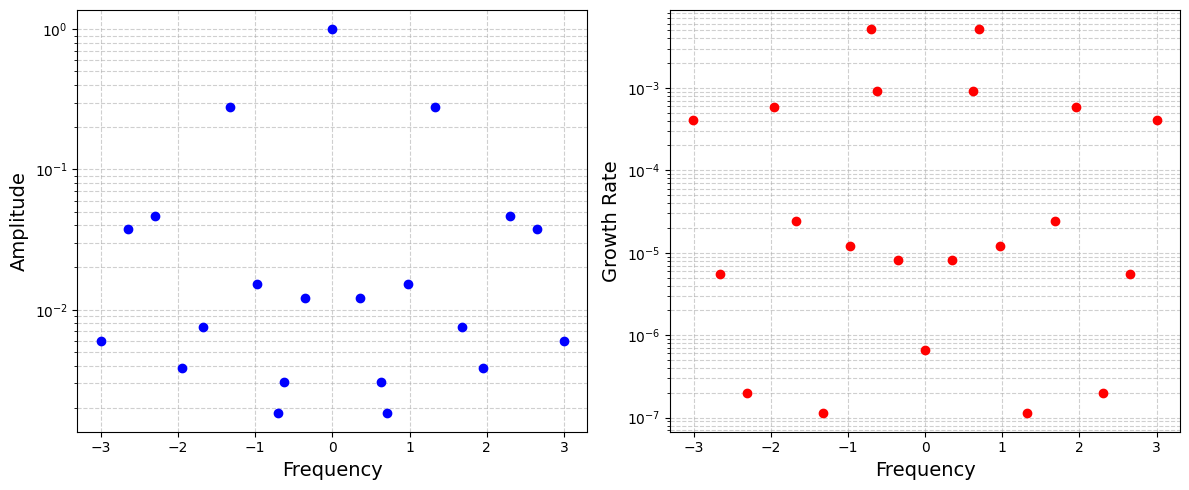

In [ ]:
# Plot Amplitude vs Frequency
fig_spec, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(Frequency, Amplitude / np.max(Amplitude), marker='o', color='b', linestyle='', markersize=6)
axes[0].set_yscale("log")
axes[0].set_xlabel("Frequency", fontsize=14)
axes[0].set_ylabel("Amplitude", fontsize=14)
axes[0].grid(True, which="both", linestyle="--", alpha=0.6)
axes[0].spines["top"].set_visible(True)
axes[0].spines["right"].set_visible(True)

# Plot Growth Rate vs Frequency
axes[1].plot(Frequency, np.abs(GrowthRate), marker='o', color='r', linestyle='', markersize=6)
axes[1].set_yscale("log")
axes[1].set_xlabel("Frequency", fontsize=14)
axes[1].set_ylabel("Growth Rate", fontsize=14)
axes[1].grid(True, which="both", linestyle="--", alpha=0.6)
axes[1].spines["top"].set_visible(True)
axes[1].spines["right"].set_visible(True)

plt.tight_layout()
plt.show()

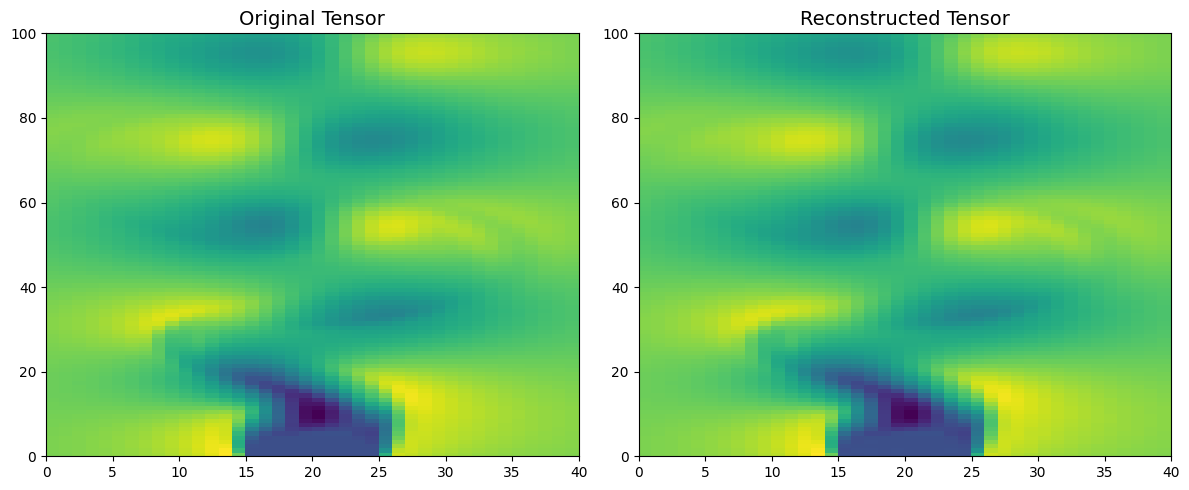

In [ ]:
# Plot Original vs Reconstruction

component = 0  # First component

if TimePos == 4:
  original_slice = Tensor[component, :, :, shape[-1]-1]
  reconstructed_slice = TT[component, :, :, shape[-1]-1]
elif TimePos == 5:
  original_slice = Tensor[component, :, :, int(shape[3]/2), shape[-1]-1]
  reconstructed_slice = TT[component, :, :, int(shape[3]/2), shape[-1]-1]

vmin, vmax = min(original_slice.min(), reconstructed_slice.min()), max(original_slice.max(), reconstructed_slice.max())

fig_rec, axes_rec = plt.subplots(1, 2, figsize=(12, 5))

# Plot original tensor
im1 = axes_rec[0].pcolor(original_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[0].set_title("Original Tensor", fontsize=14)

# Plot reconstructed tensor
im2 = axes_rec[1].pcolor(reconstructed_slice, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
axes_rec[1].set_title("Reconstructed Tensor", fontsize=14)

plt.tight_layout()
plt.show()

Real part


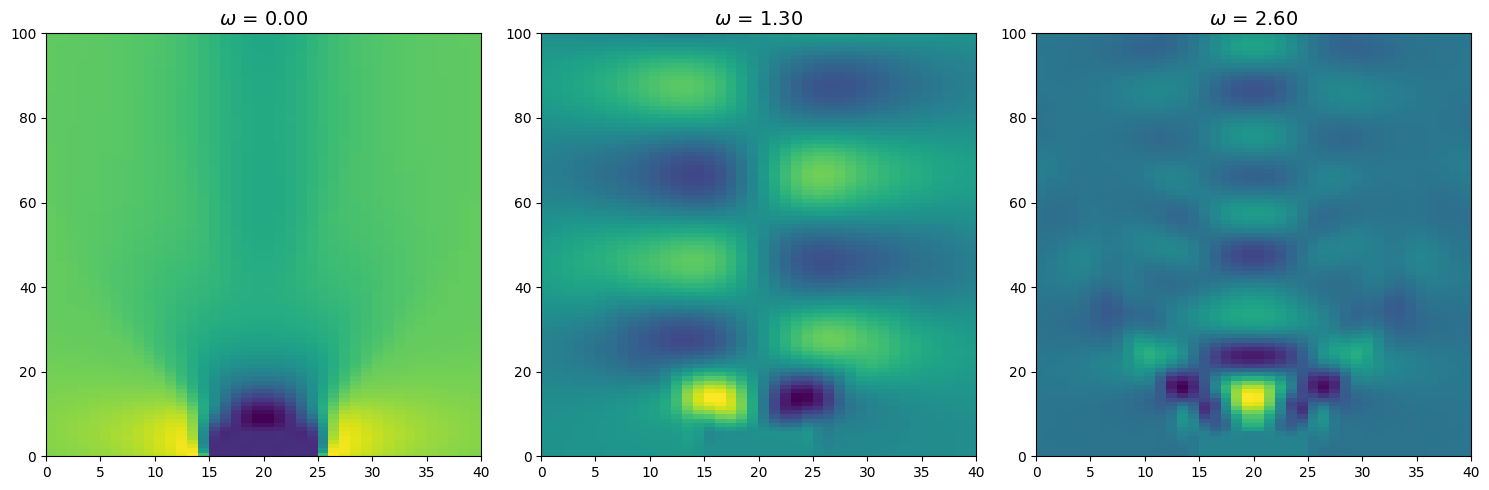

Imaginary part


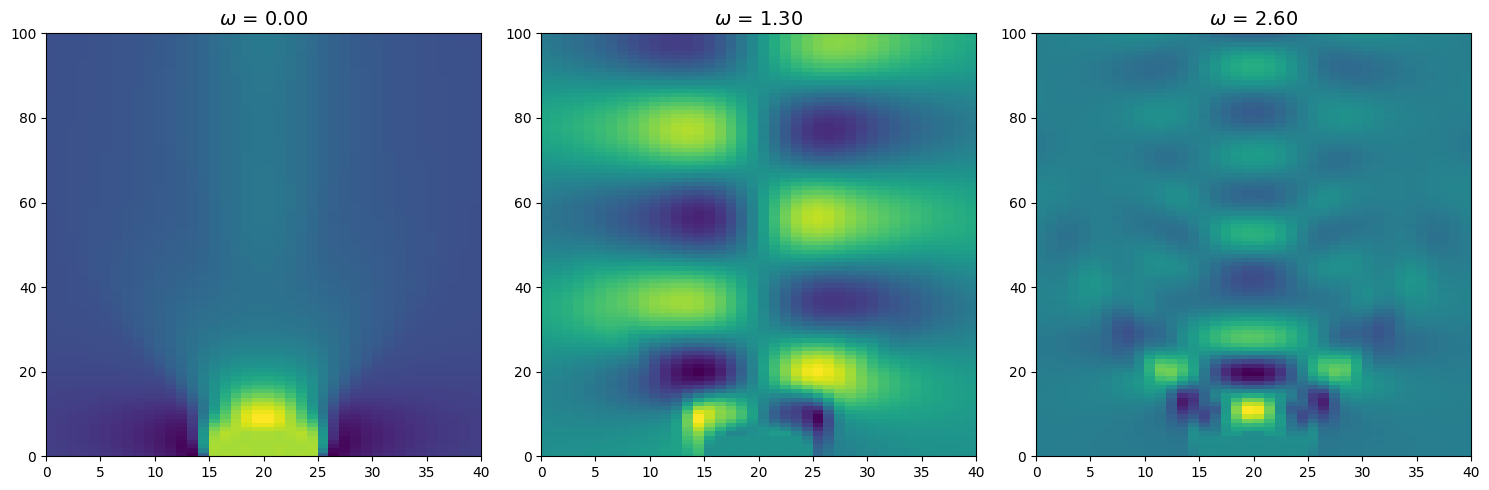

In [ ]:
# Plot DMD Modes

# Define component to visualize
component = 0

# Find desired frequencies
freq = np.array([0, 0.8, 1.6])
tolerance = 0.1  # Allowed deviation


indices = [np.argmin(np.abs(Frequency - f)) if np.any(np.abs(Frequency - f) < tolerance) else None for f in freq]

if None in indices:
    warnings.warn("Some frequencies have no match within tolerance. Skipping those modes.")

indices = [idx for idx in indices if idx is not None]

if not indices:
    raise ValueError("No frequencies matched within tolerance. Check your input data.")


# Real part of DMD mode
print('Real part')
if TimePos == 4:
  modes = [np.real(DMDmode[component,:, :, idx]) for idx in indices]
elif TimePos == 5:
  modes = [np.real(DMDmode[component,:, :, int(shape[3]/2), idx]) for idx in indices]

fig_modes, axes_modes = plt.subplots(1, len(modes), figsize=(15, 5))

for i, (ax, mode, f) in enumerate(zip(axes_modes, modes, freq)):

    vmin = min(mode.min() for mode in modes[i])
    vmax = max(mode.max() for mode in modes[i])

    im = ax.pcolor(mode, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(f"$\omega$ = {f:.2f}", fontsize=14)

plt.tight_layout()
plt.show()

# Imaginary part of DMD mode
print('Imaginary part')
if TimePos == 4:
  modes = [np.imag(DMDmode[component,:, :, idx]) for idx in indices]
elif TimePos == 5:
  modes = [np.imag(DMDmode[component,:, :, int(shape[3]/2), idx]) for idx in indices]

fig_modes, axes_modes = plt.subplots(1, len(modes), figsize=(15, 5))

for i, (ax, mode, f) in enumerate(zip(axes_modes, modes, freq)):

    vmin = min(mode.min() for mode in modes[i])
    vmax = max(mode.max() for mode in modes[i])

    im = ax.pcolor(mode, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(f"$\omega$ = {f:.2f}", fontsize=14)

plt.tight_layout()
plt.show()